# 파이토치 연습 (딥러닝)

# MNIST MLP(Multi Layer Perceptron) 설계

필요한 모듈 불러오기 및 장비 세팅

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
  Device=torch.device('cuda')
else:
  Device=torch.device('cpu')

print('Using Pytorch version:', torch.__version__, 'Device :', Device)

Using Pytorch version: 1.9.0+cu102 Device : cuda


MNIST 데이터 다운로드 받기

In [ ]:
Batch_size=32
Epochs=10

train_dataset=datasets.MNIST(root="../data/MNIST",
                             train=True, #학습용 데이터
                             download=True,
                             transform=transforms.ToTensor())
test_dataset=datasets.MNIST(root="../data/MNIST",
                            train=False, #검증용 데이터
                            transform=transforms.ToTensor())

train_loader=torch.utils.data.DataLoader(dataset=train_dataset, # Mini-Batch 단위로 할당하고자 하는 데이터셋 지정
                                         batch_size=Batch_size,
                                         shuffle=True) # 데이터 순서를 섞어, 특정 Label에 매칭된 이미지 데이터 특성만
                                         # 보고 학습합니다. (잘못된 방향, 특정 이미지 데이터에 매칭되는 Label 값만 집중적으로
                                         # 학습하는  방지하기 위해 섞어줍니다.) 
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=Batch_size,
                                        shuffle=False)

In [4]:
for (X_train, y_train) in train_loader:
  print("X_train", X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

X_train torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


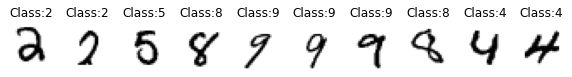

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap="gray_r")
  plt.title('Class:'+str(y_train[i].item()))

MLP 모델 설계하기
--

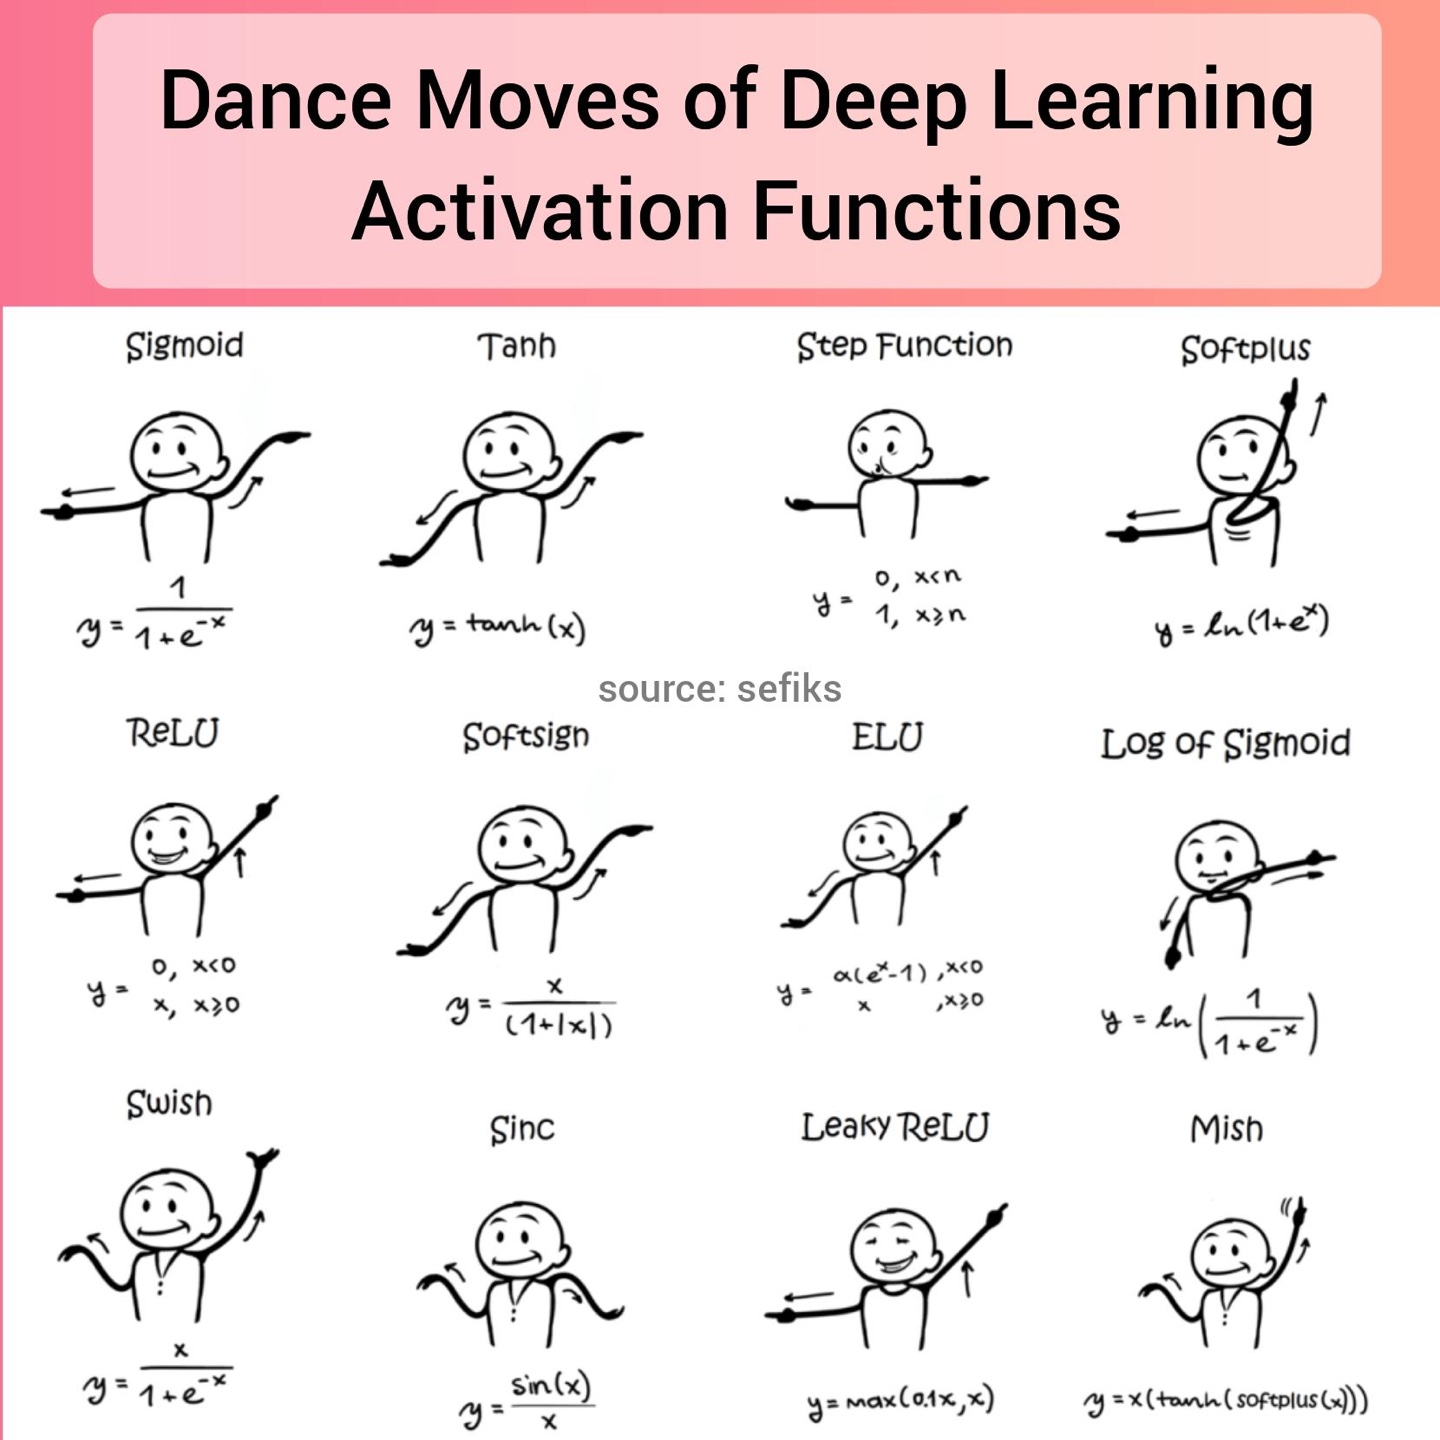

version 1: sigmoid

In [6]:
class Net_1(nn.Module):
  def __init__(self):
    super(Net_1, self).__init__()
    self.fc1=nn.Linear(28*28, 512)
    self.fc2=nn.Linear(512, 256)
    self.fc3=nn.Linear(256, 10)
  def forward(self, x):
    x=x.view(-1, 28*28)
    x=self.fc1(x)
    x=F.sigmoid(x)
    x=self.fc2(x)
    x=F.sigmoid(x)
    x=self.fc3(x)
    x=F.log_softmax(x, dim=1)
    return x

version 2: relu

In [7]:
class Net_2(nn.Module):
  def __init__(self):
    super(Net_2, self).__init__()
    self.fc1=nn.Linear(28*28, 512)
    self.fc2=nn.Linear(512, 256)
    self.fc3=nn.Linear(256, 10)
  def forward(self, x):
    x=x.view(-1, 28*28)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.fc2(x)
    x=F.relu(x)
    x=self.fc3(x)
    x=F.log_softmax(x, dim=1)
    return x

version3: Dropout + Batch Normalizaion 

In [8]:
class Net_3(nn.Module):
  def __init__(self):
    super(Net_3, self).__init__()
    self.fc1=nn.Linear(28*28, 512)
    self.fc2=nn.Linear(512, 256)
    self.fc3=nn.Linear(256, 10)
    self.dropout_prob=0.5
    self.batch_norm1=nn.BatchNorm1d(512)
    self.batch_norm2=nn.BatchNorm1d(256)
  def forward(self, x):
    x=x.view(-1, 28*28)
    x=self.fc1(x)
    x=self.batch_norm1(x)
    x=F.relu(x)
    x=F.dropout(x, training=self.training, p=self.dropout_prob)
    x=self.fc2(x)
    x=self.batch_norm2(x)
    x=F.relu(x)
    x=F.dropout(x, training=self.training, p=self.dropout_prob)
    x=self.fc3(x)
    x=F.log_softmax(x, dim=1)
    return x

Optimizer, Objectivbe Function 설정하기
--

In [9]:
model_1=Net_1().to(Device)
model_2=Net_2().to(Device)
model_3=Net_3().to(Device)

model_1: sigmoid

In [10]:
optimizer=torch.optim.SGD(model_1.parameters(), lr=0.01, momentum=0.5)
critertion=nn.CrossEntropyLoss()

In [11]:
print(model_1)

Net_1(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


modeling setting

In [12]:
def train(model, train_loader, optimizier, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    # train_loader 내에 mini-batch  단위로 저장된 데이터를 
    # 순서대로 이용해 MLP모형에 학습
    image=image.to(Device)
    label=label.to(Device)
    optimizer.zero_grad()
    # Gradient 값이 optimizer에 할당되어 있으므로,
    # optimizer의 Gradient를 초기화 합니다.
    output=model(image)
    loss=critertion(output, label)
    loss.backward() # Loss 값을 계산한 결과를 바탕으로 Back Propagatrion을 
    # 통해 계산된 Gradient 값을 각 파라미터에 할당합니다.
    optimizer.step() # 각 파라미터에 할당된 Gradient 값을 이용해 파라미터 값 업데이트

    if batch_idx % log_interval == 0:
      print(print("Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss: {:.6f}".format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item())))

evaluate

In [13]:
def evaluate(model, test_loader):
  model.eval()
  # 학습 과정 또는 학습이 완료된 상태에서 MLP 모델을 학습상태가 아닌, 
  # 평가 상태로 지정합니다.
  test_loss=0
  correct=0
  # loss값을 계산하고, 올바른 class로 분류한 경우를 세기 위해 0으로 임시 설정 
  with torch.no_grad():
    # torch.no_grad()를 메서드를 이용해 Gradient 흐름을 억제(파라미터 값 업데이터 방지)
    for image, label in test_loader:
      # Mini-Batch 내에 있는 이미지 데이터와 레이블 데이터에 반복문을 이용해 차례대로 접근
      image=image.to(Device)
      label=label.to(Device)
      output=model(image)
      test_loss += critertion(output, label).item()
      # Loss 값을 계산한 결괏값을 'test_loss'에 더해 업데이트 합니다.
      prediction=output.max(1, keepdim=True)[1]
      # MLP 모델의 Output 값은 크기가 10인 벡터 값입니다. 계산된 벡터 값 내 가장 큰 값인
      # 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단합니다.
      correct += prediction.eq(label.view_as(prediction)).sum().item()
      # MLP 모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면
      # correct 에 더해 올바르게 예측한 횟수를 저장합니다.

  test_loss /= len(test_loader.dataset)
  # 현재까지 계산된 'test_loss'의 값을 'test_loader'내에 존재하는 Mini-Batch 개수만큼
  # 나눠 평균 Loss 값으로 계산합니다.
  test_accuracy=100.*correct/len(test_loader.dataset)
  # 'test_loader' 데이터 중 얼마나 맞췄는지를 계산해 정확도를 계산합니다.
  return test_loss, test_accuracy

modeling

model_1: sigmoid

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
for Epoch in range(1, Epochs+1):
  train(model_1, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model_1, test_loader)
  print("\n [EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f} \n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)] 	 Train Loss: 2.152450
None
Train Epoch: 1 [6400/60000(11%)] 	 Train Loss: 2.172173
None
Train Epoch: 1 [12800/60000(21%)] 	 Train Loss: 2.020161
None
Train Epoch: 1 [19200/60000(32%)] 	 Train Loss: 1.800755
None
Train Epoch: 1 [25600/60000(43%)] 	 Train Loss: 1.647059
None
Train Epoch: 1 [32000/60000(53%)] 	 Train Loss: 1.563058
None
Train Epoch: 1 [38400/60000(64%)] 	 Train Loss: 1.528386
None
Train Epoch: 1 [44800/60000(75%)] 	 Train Loss: 1.570436
None
Train Epoch: 1 [51200/60000(85%)] 	 Train Loss: 1.322200
None
Train Epoch: 1 [57600/60000(96%)] 	 Train Loss: 1.038927
None

 [EPOCH: 1], 	 Test Loss: 0.0345, 	 Test Accuracy: 63.47 

Train Epoch: 2 [0/60000(0%)] 	 Train Loss: 1.183329
None
Train Epoch: 2 [6400/60000(11%)] 	 Train Loss: 1.206424
None
Train Epoch: 2 [12800/60000(21%)] 	 Train Loss: 1.212460
None
Train Epoch: 2 [19200/60000(32%)] 	 Train Loss: 0.952466
None
Train Epoch: 2 [25600/60000(43%)] 	 Train Loss: 0.845202
None
Train Epoch: 2 [32000/

- Last Test Accuracy: 90.66

model_1: relu

In [15]:
optimizer=torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.5)
critertion=nn.CrossEntropyLoss()

In [16]:
print(model_2)

Net_2(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
for Epoch in range(1, Epochs+1):
  train(model_2, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model_2, test_loader)
  print("\n [EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f} \n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)] 	 Train Loss: 2.297404
None
Train Epoch: 1 [6400/60000(11%)] 	 Train Loss: 1.943429
None
Train Epoch: 1 [12800/60000(21%)] 	 Train Loss: 1.021637
None
Train Epoch: 1 [19200/60000(32%)] 	 Train Loss: 0.528571
None
Train Epoch: 1 [25600/60000(43%)] 	 Train Loss: 0.615914
None
Train Epoch: 1 [32000/60000(53%)] 	 Train Loss: 0.767340
None
Train Epoch: 1 [38400/60000(64%)] 	 Train Loss: 0.312528
None
Train Epoch: 1 [44800/60000(75%)] 	 Train Loss: 0.378276
None
Train Epoch: 1 [51200/60000(85%)] 	 Train Loss: 0.378330
None
Train Epoch: 1 [57600/60000(96%)] 	 Train Loss: 0.424016
None

 [EPOCH: 1], 	 Test Loss: 0.0097, 	 Test Accuracy: 90.95 

Train Epoch: 2 [0/60000(0%)] 	 Train Loss: 0.870240
None
Train Epoch: 2 [6400/60000(11%)] 	 Train Loss: 0.223793
None
Train Epoch: 2 [12800/60000(21%)] 	 Train Loss: 0.411448
None
Train Epoch: 2 [19200/60000(32%)] 	 Train Loss: 0.330632
None
Train Epoch: 2 [25600/60000(43%)] 	 Train Loss: 0.076759
None
Train Epoch: 2 [32000/

- Last Test Accuracy: 97.42

version3: Dropout + Batch Normalizaion 

In [17]:
optimizer=torch.optim.SGD(model_3.parameters(), lr=0.01, momentum=0.5)
critertion=nn.CrossEntropyLoss()

In [18]:
print(model_3)

Net_3(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
for Epoch in range(1, Epochs+1):
  train(model_3, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model_3, test_loader)
  print("\n [EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f} \n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)] 	 Train Loss: 2.660653
None
Train Epoch: 1 [6400/60000(11%)] 	 Train Loss: 0.672291
None
Train Epoch: 1 [12800/60000(21%)] 	 Train Loss: 0.631034
None
Train Epoch: 1 [19200/60000(32%)] 	 Train Loss: 0.467584
None
Train Epoch: 1 [25600/60000(43%)] 	 Train Loss: 0.450937
None
Train Epoch: 1 [32000/60000(53%)] 	 Train Loss: 0.456377
None
Train Epoch: 1 [38400/60000(64%)] 	 Train Loss: 0.184232
None
Train Epoch: 1 [44800/60000(75%)] 	 Train Loss: 0.291571
None
Train Epoch: 1 [51200/60000(85%)] 	 Train Loss: 0.206418
None
Train Epoch: 1 [57600/60000(96%)] 	 Train Loss: 0.247891
None

 [EPOCH: 1], 	 Test Loss: 0.0048, 	 Test Accuracy: 95.33 

Train Epoch: 2 [0/60000(0%)] 	 Train Loss: 0.273408
None
Train Epoch: 2 [6400/60000(11%)] 	 Train Loss: 0.500225
None
Train Epoch: 2 [12800/60000(21%)] 	 Train Loss: 0.435095
None
Train Epoch: 2 [19200/60000(32%)] 	 Train Loss: 0.374717
None
Train Epoch: 2 [25600/60000(43%)] 	 Train Loss: 0.109154
None
Train Epoch: 2 [32000/

- Last Test Accuracy: 97.92

Dropout+ReLU+Batch Normalization+ He Uniform Initialization
--

> **Initialization**

>> LeCun Intialization: 각각 초기 분포가 다음과 같은 분포를 따르도록, weight를 초기화

- LeCun Normal Initialization

$$ W \sim N(0, Var(W)) $$
$$ Var(W) = \sqrt{\frac{1}{n_{in}}} $$


- LeCun Uniform Initialization

$$ W \sim U(-\sqrt{\frac{1}{n_{in}}}, +\sqrt{\frac{1}{n_{in}}}) $$

- $n_{in}$: 이전 Layer의 노드 수


>> Xavier Initialization: 이전 Layer의 노드 수와 다음 Layer의 노드 수에 따라 가중치를 결정

- Xavier Initialization

$$ W \sim N(0, Var(W)) $$

$$ Var(W) = \sqrt{\frac{1}{n_{in}+n_{out}}} $$

- Xavier Uniform Initialization

$$ W \sim U(-\sqrt{\frac{6}{n_{in}+n_{out}}}, +\sqrt{\frac{6}{n_{in}+n_{out}}}) $$

>> He Initialization: Xavier Initialization은 ReLu 함수를 사용할 때 비효율적이라는 것을 보이는데, 이를 보완한 초기화 기법




In [20]:
import torch.nn.init as init
# Weight, Bias 등 딥러닝 모델에서 초깃값으로 설정되는 요소에 대한 모듈인
# init을 임포트합니다.

def weight_init(m):
  #MLP 모델 내의 Weight를 초기화할 부분을 설정하기 위해 weight_init 함수를 정의
  if isinstance(m, nn.Linear):
    # MLP 모델을 구성하고 있는 파라미터 중 nn.Linear에 해당하는 파라미터 값에 대해서만 저장
    init.kaiming_uniform_(m.weight.data)
    # nn.Linear에 해당하는 파라미터 값에 대해 he_initialization을 이용해
    # 파라미터 값을 초기화

model=Net_3().to(Device)
model.apply(weight_init)
# apply를 이용해 모델의 파라미터 초기화. 이 때, kaiming_uniform_을 이용해 초기화(=he_initialization)
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
critertion=nn.CrossEntropyLoss()

In [23]:
for Epoch in range(1, Epochs+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model, test_loader)
  print("\n [EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f} \n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)] 	 Train Loss: 3.086564
None
Train Epoch: 1 [6400/60000(11%)] 	 Train Loss: 0.952886
None
Train Epoch: 1 [12800/60000(21%)] 	 Train Loss: 0.569961
None
Train Epoch: 1 [19200/60000(32%)] 	 Train Loss: 0.293399
None
Train Epoch: 1 [25600/60000(43%)] 	 Train Loss: 0.789966
None
Train Epoch: 1 [32000/60000(53%)] 	 Train Loss: 0.935155
None
Train Epoch: 1 [38400/60000(64%)] 	 Train Loss: 0.387318
None
Train Epoch: 1 [44800/60000(75%)] 	 Train Loss: 0.275278
None
Train Epoch: 1 [51200/60000(85%)] 	 Train Loss: 0.533432
None
Train Epoch: 1 [57600/60000(96%)] 	 Train Loss: 0.247834
None

 [EPOCH: 1], 	 Test Loss: 0.0071, 	 Test Accuracy: 93.11 

Train Epoch: 2 [0/60000(0%)] 	 Train Loss: 0.228656
None
Train Epoch: 2 [6400/60000(11%)] 	 Train Loss: 0.336379
None
Train Epoch: 2 [12800/60000(21%)] 	 Train Loss: 0.230365
None
Train Epoch: 2 [19200/60000(32%)] 	 Train Loss: 0.270746
None
Train Epoch: 2 [25600/60000(43%)] 	 Train Loss: 0.331027
None
Train Epoch: 2 [32000/

- Last Test Accuracy: 97.18

Optimizer SGD vs Adam
---

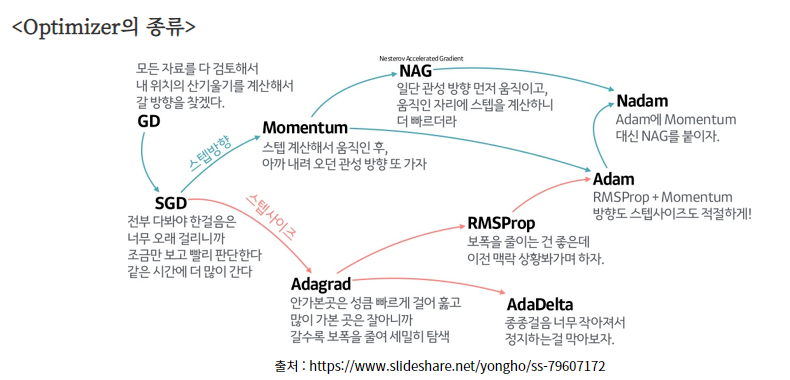

1. Stochastic gradient decent(SGD)

- full-batch가 아닌 mini batch로 학습을 진행하는 것

- (* batch로 학습하는 이유 : full-batch로 epoch마다 weight를 수정하지 않고 빠르게 mini-batch로 weight를 수정하면서 학습하기 위해)


2. Momentum

- SGD에 momentum개념을 추가한 것이다.

- 현재 batch로만 학습하는 것이 아니라 이전의 batch 학습결과도 반영한다.

3. AdaGrad

- 학습을 통해 크게 변동이 있었던 가중치에 대해서는 학습률을 감소시키고 학습을 통해 아직 가중치의 변동이 별로 없었던 가중치는 학습률을 증가시켜서 학습이 되게끔 한다.

4. RMSProp

- AdaGrad는 간단한 convex function에서 잘 동작하지만, 복잡한 다차원 곡면 function에서는 global minimum에 도달하기 전에 학습률이 0에 수렴할 수 있다. 따라서 RMSProp에서는 이를 보완하였다.

5. Adam

- Momentum과 RMSProp를 융합한 방법이다.

In [24]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
critertion=nn.CrossEntropyLoss()

In [25]:
for Epoch in range(1, Epochs+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model, test_loader)
  print("\n [EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f} \n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)] 	 Train Loss: 0.092576
None
Train Epoch: 1 [6400/60000(11%)] 	 Train Loss: 0.873888
None
Train Epoch: 1 [12800/60000(21%)] 	 Train Loss: 0.298518
None
Train Epoch: 1 [19200/60000(32%)] 	 Train Loss: 0.370098
None
Train Epoch: 1 [25600/60000(43%)] 	 Train Loss: 0.829653
None
Train Epoch: 1 [32000/60000(53%)] 	 Train Loss: 0.126080
None
Train Epoch: 1 [38400/60000(64%)] 	 Train Loss: 0.865490
None
Train Epoch: 1 [44800/60000(75%)] 	 Train Loss: 0.077587
None
Train Epoch: 1 [51200/60000(85%)] 	 Train Loss: 0.170208
None
Train Epoch: 1 [57600/60000(96%)] 	 Train Loss: 0.328799
None

 [EPOCH: 1], 	 Test Loss: 0.0038, 	 Test Accuracy: 96.38 

Train Epoch: 2 [0/60000(0%)] 	 Train Loss: 0.129086
None
Train Epoch: 2 [6400/60000(11%)] 	 Train Loss: 0.255748
None
Train Epoch: 2 [12800/60000(21%)] 	 Train Loss: 0.237498
None
Train Epoch: 2 [19200/60000(32%)] 	 Train Loss: 0.278724
None
Train Epoch: 2 [25600/60000(43%)] 	 Train Loss: 0.182676
None
Train Epoch: 2 [32000/

- Last Test Accuracy: 97.87

#AE, Stacked Auto Encoder, Denoising Auto Encoder(DAE)


Fashion MNIST를 활용해 Auto Encoder 설계
--

In [ ]:
train_dataset=datasets.FashionMNIST(root="../data/FashionMNIST",
                                    train=True,
                                    download=True,
                                    transform=transforms.ToTensor())

test_dataset=datasets.FashionMNIST(root="../data/FashionMNIST",
                                   train=False,
                                   transform=transforms.ToTensor())

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=32,
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=32,
                                        shuffle=False)

In [29]:
for (x_train, y_train) in train_loader:
  print("x_train:", x_train.size(), "type:", x_train.type())
  print("y_train:", y_train.size(), "type:", y_train.type())
  break

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


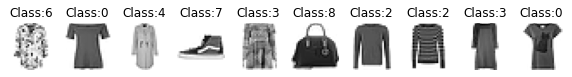

In [32]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis("off")
  plt.imshow(x_train[i, :,:,:].numpy().reshape(28, 28), cmap="gray_r")
  plt.title("Class:"+str(y_train[i].item()))

AutoEncoder(AE) 모델 설계하기
--

In [34]:
class AE(nn.Module):
    def __init__(self):
      super(AE, self).__init__()
    
      self.encoder=nn.Sequential(
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512,256),
      nn.ReLU(),
      nn.Linear(256,32),)
      
      self.decoder=nn.Sequential(
      nn.Linear(32, 256),
      nn.ReLU(),
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, 28*28),)
    
    def forward(self, x):
      encoded=self.encoder(x)
      # 이미지 데이터를 사전에 정의한 인코더의 Input을 이용해
      # Latent Variable Vector을 Encoded로 저장합니다.
      decoded=self.decoder(encoded)
      # Latent Variable Vector 값이 저장된 Encoded를 디코더의 Input으로 이용합니다.
      return encoded, decoded

In [36]:
model=AE().to(Device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
criterion=nn.MSELoss()

In [40]:
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [41]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, _) in enumerate(train_loader):
    image=image.view(-1, 28*28).to(Device)
    # AutoEncoder의 Input은 28*28 크기의 1차원 레이어므로 2차원 
    # 이미지 데이터를 1차원 데이터로 재구성해 할당합닏다.
    target=image.view(-1, 28*28).to(Device)
    optimizer.zero_grad()
    encoded, decoded=model(image)
    loss=criterion(decoded, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\t Train Loss: {:.6f}".format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))

In [46]:
def evaluate(model, test_loader):
  model.eval()
  test_loss=0
  real_image=[]
  gen_image=[]
  with torch.no_grad():
    for image, _ in test_loader:
      image=image.view(-1, 28*28).to(Device)
      target=image.view(-1, 28*28).to(Device)
      encoded, decoded = model(image)

      test_loss += criterion(decoded, image).item()
      real_image.append(image.to("cpu"))
      gen_image.append(decoded.to("cpu"))

    test_loss /= len(test_loader.dataset)

    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	 Train Loss: 0.014849
Train Epoch: 1 [6400/60000(11%)]	 Train Loss: 0.013171
Train Epoch: 1 [12800/60000(21%)]	 Train Loss: 0.012756
Train Epoch: 1 [19200/60000(32%)]	 Train Loss: 0.012773
Train Epoch: 1 [25600/60000(43%)]	 Train Loss: 0.016881
Train Epoch: 1 [32000/60000(53%)]	 Train Loss: 0.014158
Train Epoch: 1 [38400/60000(64%)]	 Train Loss: 0.013307
Train Epoch: 1 [44800/60000(75%)]	 Train Loss: 0.013021
Train Epoch: 1 [51200/60000(85%)]	 Train Loss: 0.014321
Train Epoch: 1 [57600/60000(96%)]	 Train Loss: 0.010759

[EPOCH: 1], 	 Test Loss: 0.0004


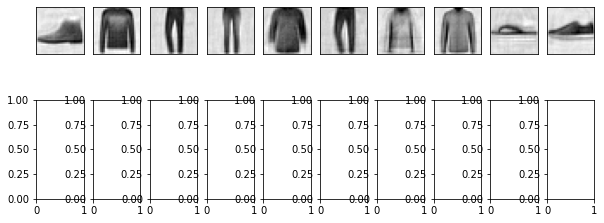

Train Epoch: 2 [0/60000(0%)]	 Train Loss: 0.013448
Train Epoch: 2 [6400/60000(11%)]	 Train Loss: 0.013786
Train Epoch: 2 [12800/60000(21%)]	 Train Loss: 0.012297
Train Epoch: 2 [19200/60000(32%)]	 Train Loss: 0.015913
Train Epoch: 2 [25600/60000(43%)]	 Train Loss: 0.014439
Train Epoch: 2 [32000/60000(53%)]	 Train Loss: 0.010306
Train Epoch: 2 [38400/60000(64%)]	 Train Loss: 0.014622
Train Epoch: 2 [44800/60000(75%)]	 Train Loss: 0.010571
Train Epoch: 2 [51200/60000(85%)]	 Train Loss: 0.010015
Train Epoch: 2 [57600/60000(96%)]	 Train Loss: 0.010997

[EPOCH: 2], 	 Test Loss: 0.0004


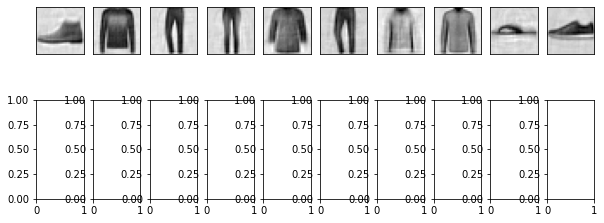

Train Epoch: 3 [0/60000(0%)]	 Train Loss: 0.010457
Train Epoch: 3 [6400/60000(11%)]	 Train Loss: 0.011475
Train Epoch: 3 [12800/60000(21%)]	 Train Loss: 0.011286
Train Epoch: 3 [19200/60000(32%)]	 Train Loss: 0.010547
Train Epoch: 3 [25600/60000(43%)]	 Train Loss: 0.009592
Train Epoch: 3 [32000/60000(53%)]	 Train Loss: 0.014770
Train Epoch: 3 [38400/60000(64%)]	 Train Loss: 0.010480
Train Epoch: 3 [44800/60000(75%)]	 Train Loss: 0.010251
Train Epoch: 3 [51200/60000(85%)]	 Train Loss: 0.012453
Train Epoch: 3 [57600/60000(96%)]	 Train Loss: 0.011324

[EPOCH: 3], 	 Test Loss: 0.0004


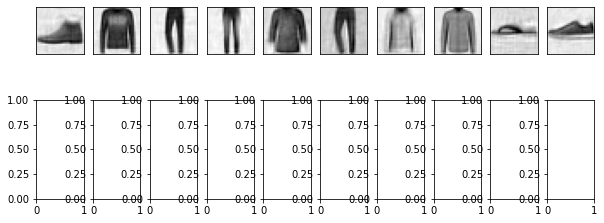

Train Epoch: 4 [0/60000(0%)]	 Train Loss: 0.013898
Train Epoch: 4 [6400/60000(11%)]	 Train Loss: 0.014232
Train Epoch: 4 [12800/60000(21%)]	 Train Loss: 0.011411
Train Epoch: 4 [19200/60000(32%)]	 Train Loss: 0.010611
Train Epoch: 4 [25600/60000(43%)]	 Train Loss: 0.010372
Train Epoch: 4 [32000/60000(53%)]	 Train Loss: 0.009989
Train Epoch: 4 [38400/60000(64%)]	 Train Loss: 0.012057
Train Epoch: 4 [44800/60000(75%)]	 Train Loss: 0.012312
Train Epoch: 4 [51200/60000(85%)]	 Train Loss: 0.011631
Train Epoch: 4 [57600/60000(96%)]	 Train Loss: 0.011092

[EPOCH: 4], 	 Test Loss: 0.0004


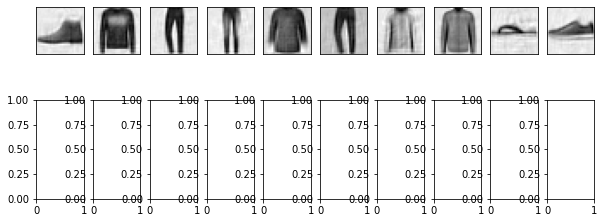

Train Epoch: 5 [0/60000(0%)]	 Train Loss: 0.009821
Train Epoch: 5 [6400/60000(11%)]	 Train Loss: 0.008328
Train Epoch: 5 [12800/60000(21%)]	 Train Loss: 0.008969
Train Epoch: 5 [19200/60000(32%)]	 Train Loss: 0.010965
Train Epoch: 5 [25600/60000(43%)]	 Train Loss: 0.009872
Train Epoch: 5 [32000/60000(53%)]	 Train Loss: 0.009896
Train Epoch: 5 [38400/60000(64%)]	 Train Loss: 0.008972
Train Epoch: 5 [44800/60000(75%)]	 Train Loss: 0.009576
Train Epoch: 5 [51200/60000(85%)]	 Train Loss: 0.010817
Train Epoch: 5 [57600/60000(96%)]	 Train Loss: 0.009188

[EPOCH: 5], 	 Test Loss: 0.0003


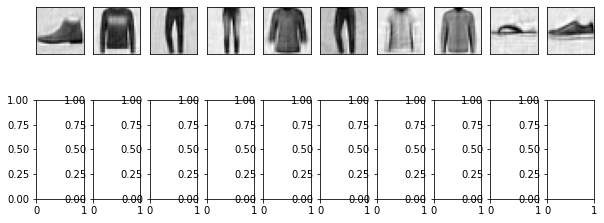

Train Epoch: 6 [0/60000(0%)]	 Train Loss: 0.008870
Train Epoch: 6 [6400/60000(11%)]	 Train Loss: 0.009739
Train Epoch: 6 [12800/60000(21%)]	 Train Loss: 0.009833
Train Epoch: 6 [19200/60000(32%)]	 Train Loss: 0.010740
Train Epoch: 6 [25600/60000(43%)]	 Train Loss: 0.009109
Train Epoch: 6 [32000/60000(53%)]	 Train Loss: 0.009611
Train Epoch: 6 [38400/60000(64%)]	 Train Loss: 0.009345
Train Epoch: 6 [44800/60000(75%)]	 Train Loss: 0.009586
Train Epoch: 6 [51200/60000(85%)]	 Train Loss: 0.008467
Train Epoch: 6 [57600/60000(96%)]	 Train Loss: 0.013049

[EPOCH: 6], 	 Test Loss: 0.0003


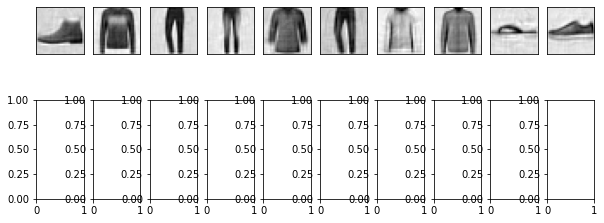

Train Epoch: 7 [0/60000(0%)]	 Train Loss: 0.008483
Train Epoch: 7 [6400/60000(11%)]	 Train Loss: 0.010474
Train Epoch: 7 [12800/60000(21%)]	 Train Loss: 0.010336
Train Epoch: 7 [19200/60000(32%)]	 Train Loss: 0.010949
Train Epoch: 7 [25600/60000(43%)]	 Train Loss: 0.010162
Train Epoch: 7 [32000/60000(53%)]	 Train Loss: 0.009844
Train Epoch: 7 [38400/60000(64%)]	 Train Loss: 0.009652
Train Epoch: 7 [44800/60000(75%)]	 Train Loss: 0.010661
Train Epoch: 7 [51200/60000(85%)]	 Train Loss: 0.008737
Train Epoch: 7 [57600/60000(96%)]	 Train Loss: 0.009755

[EPOCH: 7], 	 Test Loss: 0.0003


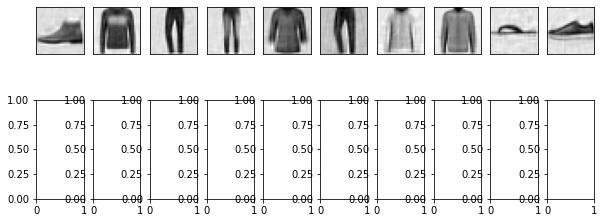

Train Epoch: 8 [0/60000(0%)]	 Train Loss: 0.009046
Train Epoch: 8 [6400/60000(11%)]	 Train Loss: 0.010357
Train Epoch: 8 [12800/60000(21%)]	 Train Loss: 0.009678
Train Epoch: 8 [19200/60000(32%)]	 Train Loss: 0.008029
Train Epoch: 8 [25600/60000(43%)]	 Train Loss: 0.009234
Train Epoch: 8 [32000/60000(53%)]	 Train Loss: 0.008558
Train Epoch: 8 [38400/60000(64%)]	 Train Loss: 0.009763
Train Epoch: 8 [44800/60000(75%)]	 Train Loss: 0.011766
Train Epoch: 8 [51200/60000(85%)]	 Train Loss: 0.012468
Train Epoch: 8 [57600/60000(96%)]	 Train Loss: 0.009375

[EPOCH: 8], 	 Test Loss: 0.0003


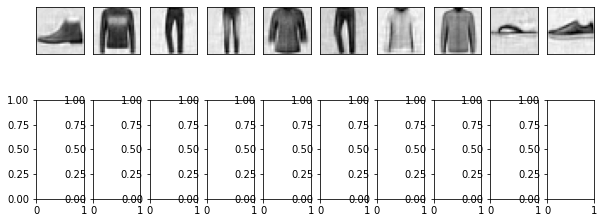

Train Epoch: 9 [0/60000(0%)]	 Train Loss: 0.010749
Train Epoch: 9 [6400/60000(11%)]	 Train Loss: 0.008898
Train Epoch: 9 [12800/60000(21%)]	 Train Loss: 0.012176
Train Epoch: 9 [19200/60000(32%)]	 Train Loss: 0.009488
Train Epoch: 9 [25600/60000(43%)]	 Train Loss: 0.008705
Train Epoch: 9 [32000/60000(53%)]	 Train Loss: 0.010510
Train Epoch: 9 [38400/60000(64%)]	 Train Loss: 0.011295
Train Epoch: 9 [44800/60000(75%)]	 Train Loss: 0.010962
Train Epoch: 9 [51200/60000(85%)]	 Train Loss: 0.008896
Train Epoch: 9 [57600/60000(96%)]	 Train Loss: 0.009152

[EPOCH: 9], 	 Test Loss: 0.0003


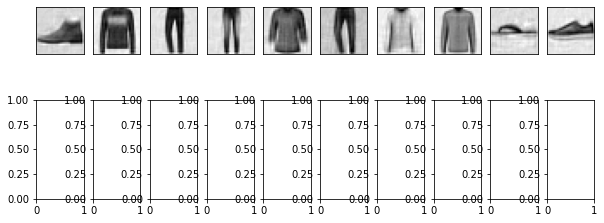

Train Epoch: 10 [0/60000(0%)]	 Train Loss: 0.012451
Train Epoch: 10 [6400/60000(11%)]	 Train Loss: 0.007646
Train Epoch: 10 [12800/60000(21%)]	 Train Loss: 0.010371
Train Epoch: 10 [19200/60000(32%)]	 Train Loss: 0.006925
Train Epoch: 10 [25600/60000(43%)]	 Train Loss: 0.009831
Train Epoch: 10 [32000/60000(53%)]	 Train Loss: 0.010304
Train Epoch: 10 [38400/60000(64%)]	 Train Loss: 0.009480
Train Epoch: 10 [44800/60000(75%)]	 Train Loss: 0.009077
Train Epoch: 10 [51200/60000(85%)]	 Train Loss: 0.010425
Train Epoch: 10 [57600/60000(96%)]	 Train Loss: 0.012438

[EPOCH: 10], 	 Test Loss: 0.0003


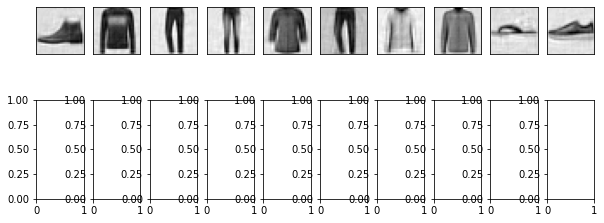

In [47]:
for Epoch in range(1, 11):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, real_image, gen_image=evaluate(model, test_loader)
  print("\n[EPOCH: {}], \t Test Loss: {:.4f}".format(Epoch, test_loss))
  f,a=plt.subplots(2,10,figsize=(10,4))
  for i in range(10):
    img=np.reshape(real_image[0][i], (28, 28))
    a[0][i].imshow(img, cmap="gray_r")
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())

  for i in range(10):
    img=np.reshape(gen_image[0][i], (28, 28))
    a[0][i].imshow(img, cmap="gray_r")
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
  plt.show()